**Name: Mudit sand**

Roll No. 203100068

Project Name: Bit_Predict

> Load the dataset

> Make sure you have downloaded the data from my github repo.... Otherwise cell is not executed.

In [1]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
#### Change the path here if you are running through my notebook
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bitpredict/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [3]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**Data Visualization**

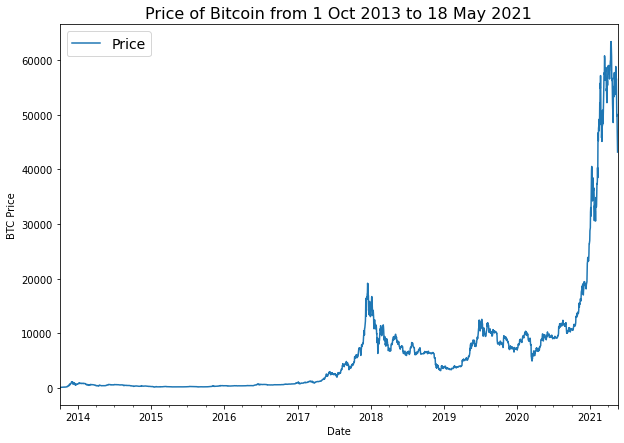

In [4]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

**N-BEATS algorithm**

You can download the paper from the following link:

https://arxiv.org/pdf/1905.10437.pdf

I have tried to replicate the Algoritham given in this paper with some tweaks due to lack of computational power.

In [5]:
import tensorflow as tf


In [6]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

> Data Preparation for N-Beats algo.

In [7]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [8]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [9]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [10]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

> For the better performance of our data with tensorflow we will use tf.data API and turn our data into batches and prefetch it.

In [11]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [12]:
N_EPOCHS = 50 # I have changed this for reducing the computation requirements.
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [13]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [14]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [15]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

>**Build Compile and Fit the N-Beat Model**

In [16]:
from tensorflow.keras import layers

In [17]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N_BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model 
model.fit(train_dataset,
          epochs=N_EPOCHS,
          validation_data=test_dataset,
            )

Epoch 1/50
3/3 [==============================] - 13s 851ms/step - loss: 1680.5603 - mae: 1680.5603 - mse: 6809710.5000 - val_loss: 14186.7207 - val_mae: 14186.7207 - val_mse: 355012768.0000
Epoch 2/50
3/3 [==============================] - 0s 131ms/step - loss: 3133.1475 - mae: 3133.1475 - mse: 52180264.0000 - val_loss: 12641.5947 - val_mae: 12641.5947 - val_mse: 282298368.0000
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 2589.9336 - mae: 2589.9336 - mse: 16834782.0000 - val_loss: 14859.9658 - val_mae: 14859.9658 - val_mse: 389368128.0000
Epoch 4/50
3/3 [==============================] - 0s 122ms/step - loss: 1963.1135 - mae: 1963.1135 - mse: 9096079.0000 - val_loss: 1344.9087 - val_mae: 1344.9087 - val_mse: 5030025.0000
Epoch 5/50
3/3 [==============================] - 0s 123ms/step - loss: 2912.5020 - mae: 2912.5017 - mse: 43476976.0000 - val_loss: 3853.3889 - val_mae: 3853.3889 - val_mse: 28962732.0000
Epoch 6/50
3/3 [==============================] - 0s 

In [18]:
# Evaluate N-BEATS model on the test dataset
model.evaluate(test_dataset)

1/1 [==============================] - 0s 45ms/step - loss: 784.5052 - mae: 784.5052 - mse: 2092674.2500


[784.5051879882812, 784.5051879882812, 2092674.25]

In [19]:
# Make predictions with N-BEATS model
model_preds = make_preds(model, test_dataset)
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9216.394 , 9108.367 , 9154.237 , 9035.553 , 8964.845 , 8911.758 ,
       8859.796 , 8766.613 , 8698.704 , 8675.8955], dtype=float32)>

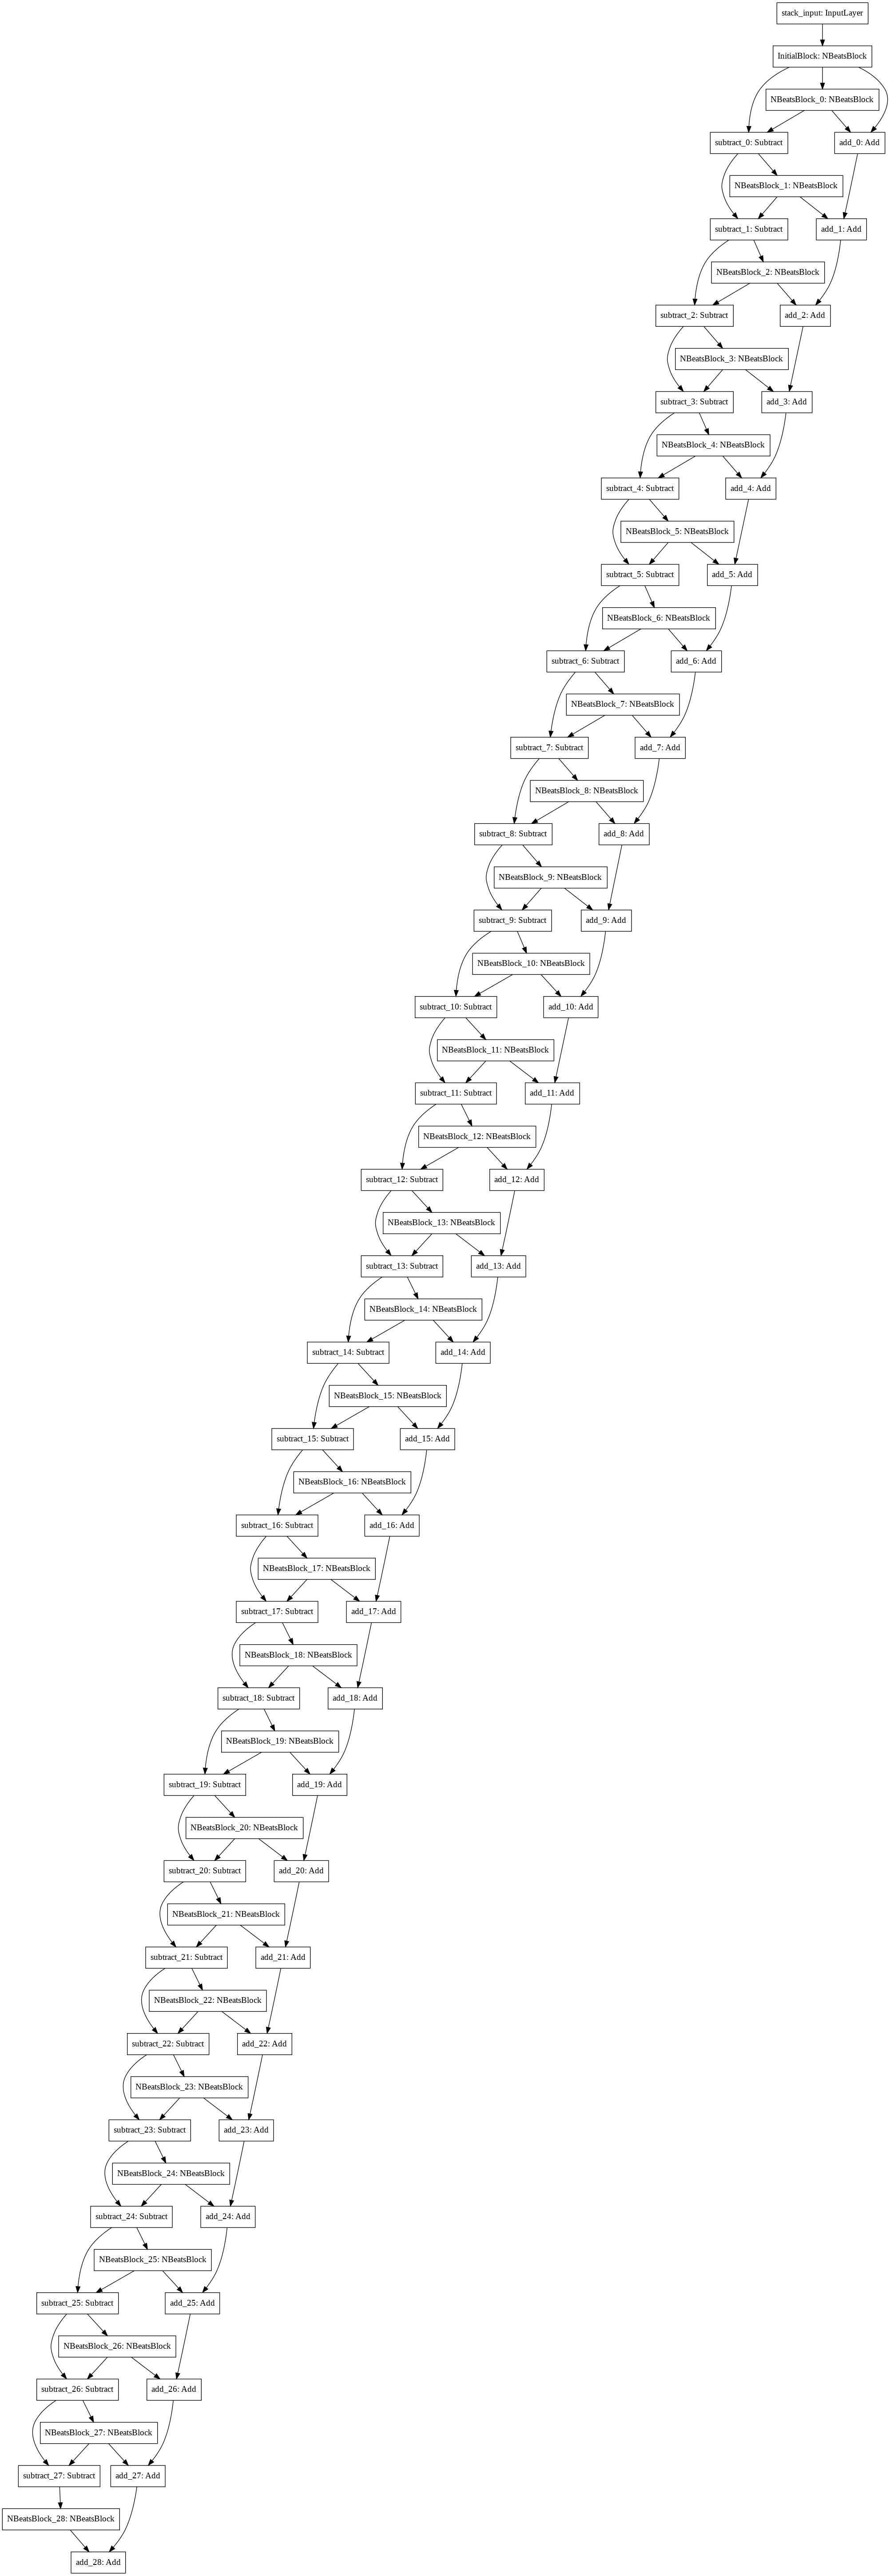

In [20]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model)

> Saving the model

In [21]:
model.save(filepath = f"/content/drive/MyDrive/Colab Notebooks/Bitpredict/{model.name}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Bitpredict/model_N_BEATS/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Bitpredict/model_N_BEATS/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


**Creating an Ensemble**

In [22]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=10, 
                        loss_fns=["mae", "mse", "mape"]):
 
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data)
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Make prediction with ensemble model.

In [23]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=5)

Optimizing model by reducing: mae for 5 epochs, model number: 0
Optimizing model by reducing: mse for 5 epochs, model number: 0
Optimizing model by reducing: mape for 5 epochs, model number: 0
Optimizing model by reducing: mae for 5 epochs, model number: 1
Optimizing model by reducing: mse for 5 epochs, model number: 1
Optimizing model by reducing: mape for 5 epochs, model number: 1
Optimizing model by reducing: mae for 5 epochs, model number: 2
Optimizing model by reducing: mse for 5 epochs, model number: 2
Optimizing model by reducing: mape for 5 epochs, model number: 2
Optimizing model by reducing: mae for 5 epochs, model number: 3
Optimizing model by reducing: mse for 5 epochs, model number: 3
Optimizing model by reducing: mape for 5 epochs, model number: 3
Optimizing model by reducing: mae for 5 epochs, model number: 4
Optimizing model by reducing: mse for 5 epochs, model number: 4
Optimizing model by reducing: mape for 5 epochs, model number: 4
CPU times: user 12.3 s, sys: 812 ms

In [24]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [25]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[12067.881 , 12048.342 , 12077.653 , ..., 74155.92  , 72907.43  ,
        68375.64  ],
       [15278.402 , 15102.519 , 14774.749 , ..., 87514.06  , 86531.94  ,
        81008.625 ],
       [10290.467 ,  9966.946 ,  9574.599 , ..., 56025.938 , 55856.023 ,
        52010.652 ],
       ...,
       [ 6999.7266,  6633.8037,  6645.409 , ..., 38714.78  , 40549.47  ,
        37506.223 ],
       [13087.358 , 12936.269 , 12523.651 , ..., 76338.28  , 75890.055 ,
        76013.086 ],
       [ 9381.314 ,  9357.757 ,  9378.447 , ..., 50988.703 , 51674.164 ,
        51585.79  ]], dtype=float32)>

In [27]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 1149.2893,
 'mape': 5.4579353,
 'mase': 2.018983,
 'mse': 3900828.0,
 'rmse': 1975.0514}

**Plotting the prediction**

In [29]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

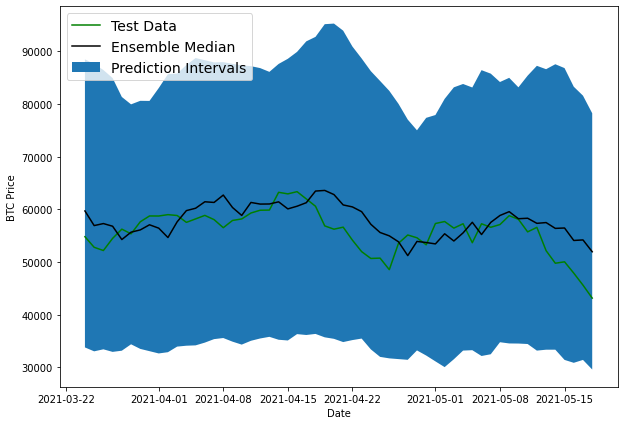

In [30]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

So we can see the our prediction is not good.
> That means that we cannot always predict and forecast the time-series correctly.

> this is due to Aleatoric uncertainty in data.